### Milestone 1 - Function Level Profiling

In [3]:
import cProfile,pstats
from mandelbort import compute_mandelbrot_naive, compute_mandelbrot_vectorized, benchmark

In [4]:
cProfile.run('compute_mandelbrot_naive(-2,1,-1.5,1.5,1024)','Naive_Profile.prof')
cProfile.run('compute_mandelbrot_vectorized(-2,1,-1.5,1.5,1024)','Numpy_Profile.prof')

for name in ('Naive_Profile.prof','Numpy_Profile.prof'):    
    stats = pstats.Stats(name)
    stats.sort_stats('cumulative')
    stats.print_stats(10)

Fri Feb 27 10:09:52 2026    Naive_Profile.prof

         23008342 function calls in 11.568 seconds

   Ordered by: cumulative time
   List reduced from 20 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   11.568   11.568 {built-in method builtins.exec}
        1    0.001    0.001   11.568   11.568 <string>:1(<module>)
        1    2.458    2.458   11.567   11.567 c:\Numerical_SC\mandelbrot-nsc\mandelbort.py:40(compute_mandelbrot_naive)
  1048576    7.737    0.000    9.109    0.000 c:\Numerical_SC\mandelbrot-nsc\mandelbort.py:60(mandelbrot_point_naive)
 21959734    1.372    0.000    1.372    0.000 {built-in method builtins.abs}
        2    0.000    0.000    0.000    0.000 c:\Users\rasm2\miniforge3\envs\nsc2026\Lib\site-packages\numpy\_core\function_base.py:26(linspace)
        2    0.000    0.000    0.000    0.000 {built-in method numpy.zeros}
        2    0.000    0.000    0.000    0.000 {built-in metho

##### Function which takes the most total time ?
Naive mandel point naive function has total time of 6.806 s

For numpy cant see any times just 0.00000 s
##### Are there any functions called suprising amount of times ? 
The absolut function is being called 21959734 times while the naive mandel point function is called 1048576 times

##### How Does the Numpy profile compare to naive ? 

It cannot find the functions/read it, as the timings for functions are all zero for the numpy

So the only thing to compare is the total time of the function of 1.001 sec vs 10.267 sec

### Milestone 2 - Line-Level Profling

The results are shown above where it can be seen most of the time is indeed in the mandbrot point naive 83.6 % of the time

Here it can be seen that the absolut takes 40.8 % of the point naive, and then 38.9 % is in the z = z**2 + c

Thereby if 83.6% is this function then we can caluculate to get the total procent of abs and z calc things

In [5]:
print((83.6*(40.8+38.9))/100)

66.62919999999998


##### cProfile on naive vs NumPy: How many functions appear in each profile? What does this difference tell you about where the work actually happens?
23008342 functions for the naive

74 functions for the numpy

it tells me that me numpy optimize the function calls need for calculating the same thing

##### line profiler on naive: Which lines dominate runtime? What fraction of total time is spent in the inner loop?

If we talk about inner loop specifcally the for j in range(num):


In [6]:
0.8 + 11.7 +83.6 +2.0 + 1.9 

100.0

The most dominiate is the 83.6% which is the naive point mandelbort specifically within this the most dominate is the abs and z=z**2 + c lines which has 40.8%  + 38.9 %

##### Based on your profiling results: why is NumPy faster than naive Python?
The functions are called less times and alot less time in total for the functinos

##### What would you need to change to make the naive version faster? (hint: what doesline profiler tell you about the inner loop?)

you would need to look at the abs and z=z**2 +c specifically i think yo look at making the operation one more then one thing at once, as it of now need to loop over and then call these operation alot of times

### Milestone 3 - Numba

In [9]:
from numba import njit
import numpy as np

@njit
def mandelbrot_point_numba(c):
    z = 0j
    max_iter = 100
    for n in range(max_iter):
        if z.real*z.real +  z.imag*z.imag > 4.0:
            return n 
        z = z**2 + c
    return max_iter 

@njit
def compute_mandelbrot_numba(x_min, x_max, y_min, y_max, num,d_type=np.float64):
    x = np.linspace(x_min, x_max, num).astype(d_type)   # real axis
    y = np.linspace(y_min, y_max, num).astype(d_type)  # imaginary axis

    # 2D arrays to store results
    all_c = np.zeros((num, num), dtype=np.complex128)
    all_n = np.zeros((num, num), dtype=np.int64)

    for i in range(num):
        for j in range(num):
            c = x[i] + 1j * y[j]
            n = mandelbrot_point_numba(c)
            all_c[i, j] = c
            all_n[i, j] = n

    return all_n

def compute_mandelbrot_hybrid(x_min, x_max, y_min, y_max, num):
    x = np.linspace(x_min, x_max, num)   # real axis
    y = np.linspace(y_min, y_max, num)   # imaginary axis

    # 2D arrays to store results
    all_c = np.zeros((num, num), dtype=np.complex128)
    all_n = np.zeros((num, num), dtype=np.int64)

    for i in range(num):
        for j in range(num):
            c = x[i] + 1j * y[j]
            n = mandelbrot_point_numba(c)
            all_c[i, j] = c
            all_n[i, j] = n

    return all_n
    


#### Run timings for hybrid and fully numba

In [10]:
_ = compute_mandelbrot_numba(-2 , 1, -1.5 , 1.5 , 1024) # warm -up
_ = compute_mandelbrot_hybrid(-2 , 1, -1.5 , 1.5 , 1024) # warm -up
median_time_numba, all_n_numba = benchmark(
        compute_mandelbrot_numba,
        -2, 1, -1.5, 1.5, 1024,
        n_runs=5, meta_prefix="Numba"
    )  
median_time_hybrid, all_n_hybrid = benchmark(
        compute_mandelbrot_hybrid,
        -2, 1, -1.5, 1.5, 1024,
        n_runs=5, meta_prefix="Numba Hybrid"
    )  
median_time_vectorized, all_n_vectorized = benchmark(
            compute_mandelbrot_vectorized,
            -2, 1, -1.5, 1.5, 1024,
            n_runs=5,meta_prefix="Numpy"
        )  
median_time_naive, all_n_naive = benchmark(
            compute_mandelbrot_naive,
            -2, 1, -1.5, 1.5, 1024,
            n_runs=5,meta_prefix="Naive"
        )  

print (f" Naive : { median_time_naive:.3f}s")
print (f" Numpy : { median_time_vectorized:.3f}s")
print (f" Hybrid Numba : { median_time_hybrid:.3f}s")
print (f" Fully compiled Numba : { median_time_numba:.3f}s")

print (f" Speed up for numpy : { median_time_naive / median_time_vectorized:.1f}x")
print (f" Speed up for hybrid numba: { median_time_naive / median_time_hybrid:.1f}x")
print (f" Speed up for fully numba: { median_time_naive / median_time_numba:.1f}x")

print(f" Extra information")
print (f" Ratio Of hybrid vs fully: { median_time_hybrid / median_time_numba:.1f}x")

 Numba with Median:0.0614s ( min =0.0612, max =0.0616)
 Numba Hybrid with Median:2.3751s ( min =2.2540, max =2.4536)
 Numpy with Median:1.4202s ( min =1.2727, max =1.5462)
 Naive with Median:7.5044s ( min =7.3584, max =8.2005)
 Naive : 7.504s
 Numpy : 1.420s
 Hybrid Numba : 2.375s
 Fully compiled Numba : 0.061s
 Speed up for numpy : 5.3x
 Speed up for hybrid numba: 3.2x
 Speed up for fully numba: 122.3x
 Extra information
 Ratio Of hybrid vs fully: 38.7x


In [21]:
for d_type in [np.float32,np.float64]:   
    _ = compute_mandelbrot_numba(-2 , 1, -1.5 , 1.5 , 1024,d_type=d_type) # warm -up
    median_time_numba, all_n_numba = benchmark(
        compute_mandelbrot_numba,
        -2, 1, -1.5, 1.5, 1024,d_type,
        n_runs=5, meta_prefix="Numba_{d_type}"
    )  

 Numba_{d_type} with Median:0.0653s ( min =0.0649, max =0.0690)
 Numba_{d_type} with Median:0.0650s ( min =0.0642, max =0.0655)


Max diff float32 vs float64: 33


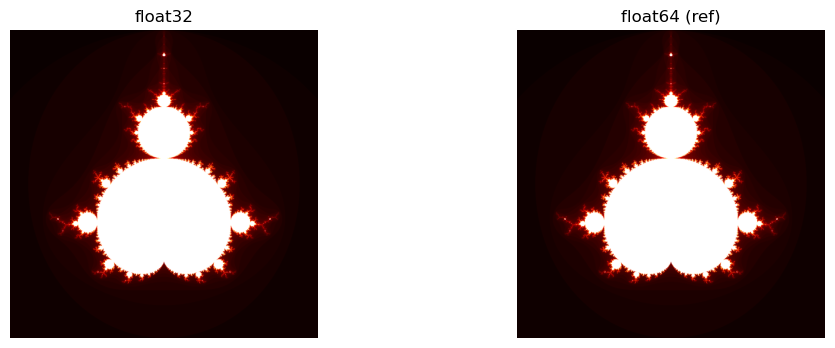

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Compute Mandelbrot results

r32 = compute_mandelbrot_numba(
    -2, 1, -1.5, 1.5, 1024, 
    d_type=np.float32
)

r64 = compute_mandelbrot_numba(
    -2, 1, -1.5, 1.5, 1024,
    d_type=np.float64
)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, result, title in zip(
    axes,
    [r32, r64],
    ["float32", "float64 (ref)"]
):
    ax.imshow(result, cmap="hot")
    ax.set_title(title)
    ax.axis("off")

plt.savefig("precision_comparison.png", dpi=150)

# Precision differences
print(f"Max diff float32 vs float64: {np.abs(r32 - r64).max()}")

##### A brief recommendation: which precision would you use and why?
Given both the float32 and float64 perform at similiary 0.0650 per iteration, man difference not comming from the d_type called just small variable when running of run time,

It would therefore make no sense to go for less bit resolution by float32 instae float64 given both perform the same in time but not in resulution



In [34]:
from numba import njit , prange

@njit( parallel=True)
def mandelbrot_point_numba_parallel(c):
    z = 0j
    max_iter = 100
    for n in prange(max_iter):
        if z.real*z.real +  z.imag*z.imag > 4.0:
            return n 
        z = z**2 + c
    return max_iter 

@njit( parallel=True)
def compute_mandelbrot_numba_parallel(x_min, x_max, y_min, y_max, num):
    x = np.linspace(x_min, x_max, num)   # real axis
    y = np.linspace(y_min, y_max, num)  # imaginary axis

    # 2D arrays to store results
    all_c = np.zeros((num, num), dtype=np.complex128)
    all_n = np.zeros((num, num), dtype=np.int64)

    for i in prange(num):
        for j in prange(num):
            c = x[i] + 1j * y[j]
            n = mandelbrot_point_numba_parallel(c)
            all_c[i, j] = c
            all_n[i, j] = n

    return all_n

_ = compute_mandelbrot_numba_parallel(-2 , 1, -1.5 , 1.5 , 1024) # warm -up
median_time_numba_parallel, all_n_numba_parallel = benchmark(
        compute_mandelbrot_numba_parallel,
        -2, 1, -1.5, 1.5, 1024,
        n_runs=5, meta_prefix="Numba_parallel"
    )  


print (f" Naive : { median_time_naive:.3f}s")
print (f" Numpy : { median_time_vectorized:.3f}s")
print (f" Hybrid Numba : { median_time_hybrid:.3f}s")
print (f" Fully compiled Numba : { median_time_numba:.3f}s")
print (f" Fully compiled Numba with parellel: { median_time_numba_parallel:.3f}s")

print (f" Speed up for numpy : { median_time_naive / median_time_vectorized:.1f}x")
print (f" Speed up for hybrid numba: { median_time_naive / median_time_hybrid:.1f}x")
print (f" Speed up for fully numba: { median_time_naive / median_time_numba:.1f}x")
print (f" Speed up for fully numba with parellel: { median_time_naive / median_time_numba_parallel:.1f}x")


C:\Users\rasm2\AppData\Local\Temp\ipykernel_29284\732718301.py:25: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "..\..\Users\rasm2\AppData\Local\Temp\ipykernel_29284\732718301.py", line 3:
<source missing, REPL/exec in use?>

  n = mandelbrot_point_numba_parallel(c)
C:\Users\rasm2\AppData\Local\Temp\ipykernel_29284\732718301.py:25: NumbaPerformanceWarning: 
prange or pndindex loop will not be executed in parallel due to there being more than one entry to or exit from the loop (e.g., an assertion).

File "..\..\Users\rasm2\AppData\Local\Temp\ipykernel_29284\732718301.py", line 7:
<source missing, REPL/exec in use?>

  n = mandelbrot_point_numba_parallel(c)


 Numba_parallel with Median:0.0145s ( min =0.0139, max =0.0154)
 Naive : 7.504s
 Numpy : 1.420s
 Hybrid Numba : 2.375s
 Fully compiled Numba : 0.065s
 Fully compiled Numba with parellel: 0.014s
 Speed up for numpy : 5.3x
 Speed up for hybrid numba: 3.2x
 Speed up for fully numba: 115.5x
 Speed up for fully numba with parellel: 518.4x
